## 2D Inverse Terzaghi Problem (PINN)

Here, we attempt to invert *two* parameters from the 2D Terzaghi PDE by using the physics to predict the unknown parameters from exact solution data. The real parameter values are $c_{x} = 0.6$ and $c_{y} = 1.0$ respectively

In [1]:
import os
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt

from sciann.utils.math import sign, abs, sigmoid, tanh, diff

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)] 



In [2]:
t_min, t_max = 0, 1
x_min, x_max = 0, 4
y_min, y_max = 0, 4

xs = np.linspace(x_min, x_max, 50)
ys = np.linspace(y_min, y_max, 50)
ts = np.linspace(t_min, t_max, 1000)

### Parameter Inversion

In [3]:
# Load exact solution file
save_directory = r'C:\Users\Umar\OneDrive\UROP_PINNs\Terzaghi\Forward\Data'

U_mesh = np.load(os.path.join(save_directory, f'2D_data_50.npy'))

# Use same format
U_mesh = U_mesh.transpose(1, 0, 2) 

In [4]:
def PrepareData(num_data=50000, random=True):
    # Flattening the mesh grid
    X, Y, T = np.meshgrid(xs, ys, ts)
    X_flat = X.flatten()[:, None]
    Y_flat = Y.flatten()[:, None]
    T_flat = T.flatten()[:, None]
    
    # Calculating U_mesh
    U_mesh_flat = U_mesh.flatten()[:, None]
    
    # Pick random data
    if random:
        idx = np.random.choice(X_flat.shape[0], num_data, replace=False)
    else:
        idx = np.arange(0, X_flat.shape[0])
    
    x_train = X_flat[idx]
    y_train = Y_flat[idx]
    t_train = T_flat[idx]
    u_train = U_mesh_flat[idx]
    
    return (x_train, y_train, t_train, u_train)

x_train, y_train, t_train, u_train = PrepareData(50000, random=True)

In [5]:
# Define new variables and functionals
sn.reset_session()
sn.set_random_seed(1234)

# Define independent variables
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

# Define solution variable
U = sn.Functional("U", [x, y, t], 8*[20], 'tanh')

# Define parameters to be inverted (Double initial value)
cx_inv = sn.Parameter(2.0, non_neg=True, inputs=[x, y, t], name="cx_inv") # 0.6
cz_inv = sn.Parameter(2.0, non_neg=True, inputs=[x, y, t], name="cz_inv") # 1.0
#cv_inv = sn.Parameter(2.0, non_neg=True, inputs=[x, y, t], name="cv_inv")

# Define PDE (physics constraint)
U_t = diff(U, t)
U_x = diff(U, x)
U_y = diff(U, y)
U_xx = diff(U_x, x)
U_yy = diff(U_y, y)

PDE = cx_inv*U_xx + cz_inv*U_yy - U_t
#PDE = cv_inv*(U_xx + U_yy) - U_t

# Define targets for MSE loss function
data_target = sn.Data(U)
pde_constraint = sn.PDE(PDE)

# Collect all targets
targets = [data_target, pde_constraint]

In [6]:
epochs = 1000
batch_size = 5000

model_inv = sn.SciModel(
    inputs=[x, y, t],
    targets=targets,
    loss_func="mse"
)

input_data = [x_train, y_train, t_train]
target_data = [u_train, 'zeros']

# Prepare the training input and target data
H_new = model_inv.train(
    input_data,
    target_data,
    epochs=epochs,
    batch_size=batch_size,
    stop_loss_value=1e-36,
    learning_rate=([0, 1000], [0.001, 0.0005]),
    stop_after=None,
    verbose=2,
    log_parameters={'parameters': [cx_inv, cz_inv], 'freq': 1}
)
model_inv.save_weights('Inverse2DWeights.hdf5')


Total samples: 50000 
Batch size: 5000 
Total batches: 10 

Epoch 1/1000
10/10 - 4s - loss: 0.2620 - U_loss: 0.1556 - sub_loss: 0.1064 - lr: 0.0010 - time: 3.9639 - cx_inv: 1.9904 - cz_inv: 1.9910 - 4s/epoch - 401ms/step
Epoch 2/1000
10/10 - 0s - loss: 0.1327 - U_loss: 0.1165 - sub_loss: 0.0162 - lr: 9.9950e-04 - time: 0.3051 - cx_inv: 1.9830 - cz_inv: 1.9853 - 306ms/epoch - 31ms/step
Epoch 3/1000
10/10 - 0s - loss: 0.1150 - U_loss: 0.1103 - sub_loss: 0.0047 - lr: 9.9900e-04 - time: 0.3500 - cx_inv: 1.9786 - cz_inv: 1.9826 - 352ms/epoch - 35ms/step
Epoch 4/1000
10/10 - 0s - loss: 0.1103 - U_loss: 0.1074 - sub_loss: 0.0029 - lr: 9.9850e-04 - time: 0.3188 - cx_inv: 1.9757 - cz_inv: 1.9813 - 320ms/epoch - 32ms/step
Epoch 5/1000
10/10 - 0s - loss: 0.1066 - U_loss: 0.1049 - sub_loss: 0.0017 - lr: 9.9800e-04 - time: 0.3569 - cx_inv: 1.9735 - cz_inv: 1.9806 - 357ms/epoch - 36ms/step
Epoch 6/1000
10/10 - 0s - loss: 0.1023 - U_loss: 0.1008 - sub_loss: 0.0015 - lr: 9.9750e-04 - time: 0.2921 - c

Epoch 50/1000
10/10 - 0s - loss: 0.0093 - U_loss: 0.0083 - sub_loss: 9.7170e-04 - lr: 9.7550e-04 - time: 0.3225 - cx_inv: 1.6879 - cz_inv: 1.8507 - 324ms/epoch - 32ms/step
Epoch 51/1000
10/10 - 0s - loss: 0.0091 - U_loss: 0.0082 - sub_loss: 9.0936e-04 - lr: 9.7500e-04 - time: 0.3214 - cx_inv: 1.6794 - cz_inv: 1.8462 - 321ms/epoch - 32ms/step
Epoch 52/1000
10/10 - 0s - loss: 0.0088 - U_loss: 0.0079 - sub_loss: 9.4212e-04 - lr: 9.7450e-04 - time: 0.3255 - cx_inv: 1.6710 - cz_inv: 1.8417 - 327ms/epoch - 33ms/step
Epoch 53/1000
10/10 - 0s - loss: 0.0088 - U_loss: 0.0078 - sub_loss: 9.4412e-04 - lr: 9.7400e-04 - time: 0.3193 - cx_inv: 1.6624 - cz_inv: 1.8371 - 319ms/epoch - 32ms/step
Epoch 54/1000
10/10 - 0s - loss: 0.0087 - U_loss: 0.0078 - sub_loss: 8.8381e-04 - lr: 9.7350e-04 - time: 0.3297 - cx_inv: 1.6539 - cz_inv: 1.8326 - 330ms/epoch - 33ms/step
Epoch 55/1000
10/10 - 0s - loss: 0.0085 - U_loss: 0.0076 - sub_loss: 8.5471e-04 - lr: 9.7300e-04 - time: 0.3163 - cx_inv: 1.6454 - cz_inv: 1

Epoch 98/1000
10/10 - 0s - loss: 0.0050 - U_loss: 0.0045 - sub_loss: 4.6681e-04 - lr: 9.5150e-04 - time: 0.3209 - cx_inv: 1.2910 - cz_inv: 1.6286 - 321ms/epoch - 32ms/step
Epoch 99/1000
10/10 - 0s - loss: 0.0049 - U_loss: 0.0044 - sub_loss: 4.5374e-04 - lr: 9.5100e-04 - time: 0.3308 - cx_inv: 1.2835 - cz_inv: 1.6241 - 332ms/epoch - 33ms/step
Epoch 100/1000
10/10 - 0s - loss: 0.0047 - U_loss: 0.0043 - sub_loss: 4.4952e-04 - lr: 9.5050e-04 - time: 0.3169 - cx_inv: 1.2760 - cz_inv: 1.6197 - 318ms/epoch - 32ms/step
Epoch 101/1000
10/10 - 0s - loss: 0.0046 - U_loss: 0.0042 - sub_loss: 4.6604e-04 - lr: 9.5000e-04 - time: 0.3258 - cx_inv: 1.2685 - cz_inv: 1.6153 - 327ms/epoch - 33ms/step
Epoch 102/1000
10/10 - 0s - loss: 0.0047 - U_loss: 0.0042 - sub_loss: 4.5948e-04 - lr: 9.4950e-04 - time: 0.3174 - cx_inv: 1.2611 - cz_inv: 1.6108 - 318ms/epoch - 32ms/step
Epoch 103/1000
10/10 - 0s - loss: 0.0048 - U_loss: 0.0044 - sub_loss: 4.4151e-04 - lr: 9.4900e-04 - time: 0.3240 - cx_inv: 1.2538 - cz_in

Epoch 146/1000
10/10 - 0s - loss: 0.0030 - U_loss: 0.0027 - sub_loss: 3.2672e-04 - lr: 9.2750e-04 - time: 0.3278 - cx_inv: 0.9916 - cz_inv: 1.4334 - 328ms/epoch - 33ms/step
Epoch 147/1000
10/10 - 0s - loss: 0.0031 - U_loss: 0.0027 - sub_loss: 3.7397e-04 - lr: 9.2700e-04 - time: 0.3212 - cx_inv: 0.9869 - cz_inv: 1.4298 - 321ms/epoch - 32ms/step
Epoch 148/1000
10/10 - 0s - loss: 0.0030 - U_loss: 0.0026 - sub_loss: 3.9301e-04 - lr: 9.2650e-04 - time: 0.3233 - cx_inv: 0.9824 - cz_inv: 1.4262 - 323ms/epoch - 32ms/step
Epoch 149/1000
10/10 - 0s - loss: 0.0028 - U_loss: 0.0025 - sub_loss: 3.3245e-04 - lr: 9.2600e-04 - time: 0.3213 - cx_inv: 0.9778 - cz_inv: 1.4226 - 322ms/epoch - 32ms/step
Epoch 150/1000
10/10 - 0s - loss: 0.0027 - U_loss: 0.0024 - sub_loss: 3.1467e-04 - lr: 9.2550e-04 - time: 0.3125 - cx_inv: 0.9732 - cz_inv: 1.4190 - 314ms/epoch - 31ms/step
Epoch 151/1000
10/10 - 0s - loss: 0.0027 - U_loss: 0.0024 - sub_loss: 3.0379e-04 - lr: 9.2500e-04 - time: 0.3265 - cx_inv: 0.9688 - cz_

Epoch 194/1000
10/10 - 0s - loss: 0.0021 - U_loss: 0.0018 - sub_loss: 3.3606e-04 - lr: 9.0350e-04 - time: 0.3319 - cx_inv: 0.8369 - cz_inv: 1.2870 - 332ms/epoch - 33ms/step
Epoch 195/1000
10/10 - 0s - loss: 0.0020 - U_loss: 0.0017 - sub_loss: 3.1827e-04 - lr: 9.0300e-04 - time: 0.3177 - cx_inv: 0.8349 - cz_inv: 1.2846 - 319ms/epoch - 32ms/step
Epoch 196/1000
10/10 - 0s - loss: 0.0021 - U_loss: 0.0018 - sub_loss: 3.1864e-04 - lr: 9.0250e-04 - time: 0.3224 - cx_inv: 0.8329 - cz_inv: 1.2823 - 322ms/epoch - 32ms/step
Epoch 197/1000
10/10 - 0s - loss: 0.0021 - U_loss: 0.0018 - sub_loss: 3.3843e-04 - lr: 9.0200e-04 - time: 0.3243 - cx_inv: 0.8310 - cz_inv: 1.2799 - 324ms/epoch - 32ms/step
Epoch 198/1000
10/10 - 0s - loss: 0.0019 - U_loss: 0.0016 - sub_loss: 2.8349e-04 - lr: 9.0150e-04 - time: 0.3251 - cx_inv: 0.8292 - cz_inv: 1.2776 - 325ms/epoch - 33ms/step
Epoch 199/1000
10/10 - 0s - loss: 0.0019 - U_loss: 0.0016 - sub_loss: 3.1972e-04 - lr: 9.0100e-04 - time: 0.3228 - cx_inv: 0.8273 - cz_

Epoch 242/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0013 - sub_loss: 2.4354e-04 - lr: 8.7950e-04 - time: 0.3263 - cx_inv: 0.7730 - cz_inv: 1.2010 - 327ms/epoch - 33ms/step
Epoch 243/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0013 - sub_loss: 2.4721e-04 - lr: 8.7900e-04 - time: 0.3206 - cx_inv: 0.7722 - cz_inv: 1.1997 - 321ms/epoch - 32ms/step
Epoch 244/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0013 - sub_loss: 2.4430e-04 - lr: 8.7850e-04 - time: 0.3213 - cx_inv: 0.7713 - cz_inv: 1.1985 - 322ms/epoch - 32ms/step
Epoch 245/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0013 - sub_loss: 2.4820e-04 - lr: 8.7800e-04 - time: 0.3244 - cx_inv: 0.7706 - cz_inv: 1.1973 - 324ms/epoch - 32ms/step
Epoch 246/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0012 - sub_loss: 2.4869e-04 - lr: 8.7750e-04 - time: 0.3476 - cx_inv: 0.7696 - cz_inv: 1.1961 - 349ms/epoch - 35ms/step
Epoch 247/1000
10/10 - 0s - loss: 0.0015 - U_loss: 0.0013 - sub_loss: 2.5306e-04 - lr: 8.7700e-04 - time: 0.3036 - cx_inv: 0.7689 - cz_

Epoch 290/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0011 - sub_loss: 2.7257e-04 - lr: 8.5550e-04 - time: 0.3240 - cx_inv: 0.7436 - cz_inv: 1.1575 - 325ms/epoch - 32ms/step
Epoch 291/1000
10/10 - 0s - loss: 0.0014 - U_loss: 0.0011 - sub_loss: 2.9601e-04 - lr: 8.5500e-04 - time: 0.3263 - cx_inv: 0.7432 - cz_inv: 1.1568 - 327ms/epoch - 33ms/step
Epoch 292/1000
10/10 - 0s - loss: 0.0013 - U_loss: 0.0010 - sub_loss: 2.4106e-04 - lr: 8.5450e-04 - time: 0.3533 - cx_inv: 0.7428 - cz_inv: 1.1562 - 354ms/epoch - 35ms/step
Epoch 293/1000
10/10 - 0s - loss: 0.0012 - U_loss: 0.0010 - sub_loss: 2.2043e-04 - lr: 8.5400e-04 - time: 0.3091 - cx_inv: 0.7424 - cz_inv: 1.1556 - 310ms/epoch - 31ms/step
Epoch 294/1000
10/10 - 0s - loss: 0.0013 - U_loss: 0.0010 - sub_loss: 2.2659e-04 - lr: 8.5350e-04 - time: 0.3299 - cx_inv: 0.7419 - cz_inv: 1.1550 - 331ms/epoch - 33ms/step
Epoch 295/1000
10/10 - 0s - loss: 0.0012 - U_loss: 0.0010 - sub_loss: 2.3458e-04 - lr: 8.5300e-04 - time: 0.3125 - cx_inv: 0.7416 - cz_

Epoch 337/1000
10/10 - 0s - loss: 0.0012 - U_loss: 9.1258e-04 - sub_loss: 2.5816e-04 - lr: 8.3200e-04 - time: 0.3171 - cx_inv: 0.7291 - cz_inv: 1.1361 - 317ms/epoch - 32ms/step
Epoch 338/1000
10/10 - 0s - loss: 0.0011 - U_loss: 9.0506e-04 - sub_loss: 2.4244e-04 - lr: 8.3150e-04 - time: 0.3213 - cx_inv: 0.7289 - cz_inv: 1.1358 - 322ms/epoch - 32ms/step
Epoch 339/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.8311e-04 - sub_loss: 2.3377e-04 - lr: 8.3100e-04 - time: 0.3257 - cx_inv: 0.7286 - cz_inv: 1.1355 - 327ms/epoch - 33ms/step
Epoch 340/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.9183e-04 - sub_loss: 2.2534e-04 - lr: 8.3050e-04 - time: 0.3127 - cx_inv: 0.7283 - cz_inv: 1.1351 - 314ms/epoch - 31ms/step
Epoch 341/1000
10/10 - 0s - loss: 0.0012 - U_loss: 9.3654e-04 - sub_loss: 2.3100e-04 - lr: 8.3000e-04 - time: 0.3268 - cx_inv: 0.7281 - cz_inv: 1.1348 - 328ms/epoch - 33ms/step
Epoch 342/1000
10/10 - 0s - loss: 0.0013 - U_loss: 9.8626e-04 - sub_loss: 2.7804e-04 - lr: 8.2950e-04 - time: 0.323

Epoch 384/1000
10/10 - 0s - loss: 0.0010 - U_loss: 7.8991e-04 - sub_loss: 2.3168e-04 - lr: 8.0850e-04 - time: 0.3128 - cx_inv: 0.7207 - cz_inv: 1.1244 - 314ms/epoch - 31ms/step
Epoch 385/1000
10/10 - 0s - loss: 0.0010 - U_loss: 8.1800e-04 - sub_loss: 1.9974e-04 - lr: 8.0800e-04 - time: 0.3310 - cx_inv: 0.7205 - cz_inv: 1.1242 - 332ms/epoch - 33ms/step
Epoch 386/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.4735e-04 - sub_loss: 2.2124e-04 - lr: 8.0750e-04 - time: 0.3205 - cx_inv: 0.7205 - cz_inv: 1.1241 - 321ms/epoch - 32ms/step
Epoch 387/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.4915e-04 - sub_loss: 2.7635e-04 - lr: 8.0700e-04 - time: 0.3207 - cx_inv: 0.7205 - cz_inv: 1.1238 - 321ms/epoch - 32ms/step
Epoch 388/1000
10/10 - 0s - loss: 9.7861e-04 - U_loss: 7.8325e-04 - sub_loss: 1.9535e-04 - lr: 8.0650e-04 - time: 0.3225 - cx_inv: 0.7203 - cz_inv: 1.1236 - 324ms/epoch - 32ms/step
Epoch 389/1000
10/10 - 0s - loss: 0.0010 - U_loss: 8.0810e-04 - sub_loss: 2.4002e-04 - lr: 8.0600e-04 - time: 0

Epoch 430/1000
10/10 - 0s - loss: 0.0011 - U_loss: 8.4105e-04 - sub_loss: 2.3430e-04 - lr: 7.8550e-04 - time: 0.3062 - cx_inv: 0.7159 - cz_inv: 1.1170 - 306ms/epoch - 31ms/step
Epoch 431/1000
10/10 - 0s - loss: 9.9771e-04 - U_loss: 7.3468e-04 - sub_loss: 2.6304e-04 - lr: 7.8500e-04 - time: 0.3134 - cx_inv: 0.7159 - cz_inv: 1.1170 - 314ms/epoch - 31ms/step
Epoch 432/1000
10/10 - 0s - loss: 0.0010 - U_loss: 7.6341e-04 - sub_loss: 2.4087e-04 - lr: 7.8450e-04 - time: 0.3392 - cx_inv: 0.7159 - cz_inv: 1.1168 - 340ms/epoch - 34ms/step
Epoch 433/1000
10/10 - 0s - loss: 9.5535e-04 - U_loss: 7.2930e-04 - sub_loss: 2.2604e-04 - lr: 7.8400e-04 - time: 0.3087 - cx_inv: 0.7157 - cz_inv: 1.1166 - 310ms/epoch - 31ms/step
Epoch 434/1000
10/10 - 0s - loss: 9.3906e-04 - U_loss: 7.2144e-04 - sub_loss: 2.1762e-04 - lr: 7.8350e-04 - time: 0.3110 - cx_inv: 0.7156 - cz_inv: 1.1165 - 312ms/epoch - 31ms/step
Epoch 435/1000
10/10 - 0s - loss: 9.2930e-04 - U_loss: 7.1388e-04 - sub_loss: 2.1541e-04 - lr: 7.8300e-

Epoch 476/1000
10/10 - 0s - loss: 9.5791e-04 - U_loss: 6.8708e-04 - sub_loss: 2.7084e-04 - lr: 7.6250e-04 - time: 0.3370 - cx_inv: 0.7128 - cz_inv: 1.1117 - 337ms/epoch - 34ms/step
Epoch 477/1000
10/10 - 0s - loss: 8.1743e-04 - U_loss: 6.4754e-04 - sub_loss: 1.6989e-04 - lr: 7.6200e-04 - time: 0.2969 - cx_inv: 0.7128 - cz_inv: 1.1116 - 297ms/epoch - 30ms/step
Epoch 478/1000
10/10 - 0s - loss: 7.9214e-04 - U_loss: 6.5231e-04 - sub_loss: 1.3983e-04 - lr: 7.6150e-04 - time: 0.3278 - cx_inv: 0.7128 - cz_inv: 1.1115 - 328ms/epoch - 33ms/step
Epoch 479/1000
10/10 - 0s - loss: 8.9853e-04 - U_loss: 7.1064e-04 - sub_loss: 1.8789e-04 - lr: 7.6100e-04 - time: 0.3252 - cx_inv: 0.7128 - cz_inv: 1.1114 - 326ms/epoch - 33ms/step
Epoch 480/1000
10/10 - 0s - loss: 0.0012 - U_loss: 8.0959e-04 - sub_loss: 3.5275e-04 - lr: 7.6050e-04 - time: 0.3409 - cx_inv: 0.7127 - cz_inv: 1.1113 - 341ms/epoch - 34ms/step
Epoch 481/1000
10/10 - 0s - loss: 0.0011 - U_loss: 7.7541e-04 - sub_loss: 3.5654e-04 - lr: 7.6000e-

Epoch 522/1000
10/10 - 0s - loss: 7.7597e-04 - U_loss: 6.0857e-04 - sub_loss: 1.6740e-04 - lr: 7.3950e-04 - time: 0.3261 - cx_inv: 0.7106 - cz_inv: 1.1075 - 326ms/epoch - 33ms/step
Epoch 523/1000
10/10 - 0s - loss: 7.3769e-04 - U_loss: 6.1138e-04 - sub_loss: 1.2631e-04 - lr: 7.3900e-04 - time: 0.3230 - cx_inv: 0.7105 - cz_inv: 1.1074 - 324ms/epoch - 32ms/step
Epoch 524/1000
10/10 - 0s - loss: 7.3483e-04 - U_loss: 6.0724e-04 - sub_loss: 1.2759e-04 - lr: 7.3850e-04 - time: 0.3227 - cx_inv: 0.7105 - cz_inv: 1.1073 - 324ms/epoch - 32ms/step
Epoch 525/1000
10/10 - 0s - loss: 8.0793e-04 - U_loss: 6.3555e-04 - sub_loss: 1.7237e-04 - lr: 7.3800e-04 - time: 0.3242 - cx_inv: 0.7104 - cz_inv: 1.1073 - 324ms/epoch - 32ms/step
Epoch 526/1000
10/10 - 0s - loss: 9.9689e-04 - U_loss: 6.7251e-04 - sub_loss: 3.2438e-04 - lr: 7.3750e-04 - time: 0.3198 - cx_inv: 0.7104 - cz_inv: 1.1072 - 320ms/epoch - 32ms/step
Epoch 527/1000
10/10 - 0s - loss: 9.1483e-04 - U_loss: 6.4270e-04 - sub_loss: 2.7213e-04 - lr: 

Epoch 568/1000
10/10 - 0s - loss: 7.0797e-04 - U_loss: 5.6364e-04 - sub_loss: 1.4432e-04 - lr: 7.1650e-04 - time: 0.3199 - cx_inv: 0.7085 - cz_inv: 1.1042 - 321ms/epoch - 32ms/step
Epoch 569/1000
10/10 - 0s - loss: 6.9504e-04 - U_loss: 5.8258e-04 - sub_loss: 1.1246e-04 - lr: 7.1600e-04 - time: 0.3262 - cx_inv: 0.7084 - cz_inv: 1.1042 - 327ms/epoch - 33ms/step
Epoch 570/1000
10/10 - 0s - loss: 7.1020e-04 - U_loss: 5.8640e-04 - sub_loss: 1.2380e-04 - lr: 7.1550e-04 - time: 0.3245 - cx_inv: 0.7084 - cz_inv: 1.1041 - 325ms/epoch - 33ms/step
Epoch 571/1000
10/10 - 0s - loss: 6.7322e-04 - U_loss: 5.6647e-04 - sub_loss: 1.0675e-04 - lr: 7.1500e-04 - time: 0.3196 - cx_inv: 0.7083 - cz_inv: 1.1041 - 321ms/epoch - 32ms/step
Epoch 572/1000
10/10 - 0s - loss: 7.1812e-04 - U_loss: 5.7680e-04 - sub_loss: 1.4131e-04 - lr: 7.1450e-04 - time: 0.3312 - cx_inv: 0.7082 - cz_inv: 1.1040 - 332ms/epoch - 33ms/step
Epoch 573/1000
10/10 - 0s - loss: 7.3966e-04 - U_loss: 5.9790e-04 - sub_loss: 1.4175e-04 - lr: 

Epoch 614/1000
10/10 - 0s - loss: 8.4553e-04 - U_loss: 6.9765e-04 - sub_loss: 1.4789e-04 - lr: 6.9350e-04 - time: 0.3950 - cx_inv: 0.7064 - cz_inv: 1.1016 - 395ms/epoch - 40ms/step
Epoch 615/1000
10/10 - 0s - loss: 8.0966e-04 - U_loss: 6.3777e-04 - sub_loss: 1.7189e-04 - lr: 6.9300e-04 - time: 0.3275 - cx_inv: 0.7065 - cz_inv: 1.1017 - 328ms/epoch - 33ms/step
Epoch 616/1000
10/10 - 0s - loss: 6.9203e-04 - U_loss: 5.6254e-04 - sub_loss: 1.2949e-04 - lr: 6.9250e-04 - time: 0.3068 - cx_inv: 0.7064 - cz_inv: 1.1016 - 308ms/epoch - 31ms/step
Epoch 617/1000
10/10 - 0s - loss: 6.5229e-04 - U_loss: 5.4192e-04 - sub_loss: 1.1037e-04 - lr: 6.9200e-04 - time: 0.2995 - cx_inv: 0.7064 - cz_inv: 1.1015 - 301ms/epoch - 30ms/step
Epoch 618/1000
10/10 - 0s - loss: 6.5645e-04 - U_loss: 5.3728e-04 - sub_loss: 1.1918e-04 - lr: 6.9150e-04 - time: 0.3185 - cx_inv: 0.7063 - cz_inv: 1.1015 - 319ms/epoch - 32ms/step
Epoch 619/1000
10/10 - 0s - loss: 6.5388e-04 - U_loss: 5.3741e-04 - sub_loss: 1.1647e-04 - lr: 

Epoch 660/1000
10/10 - 0s - loss: 8.3862e-04 - U_loss: 5.3445e-04 - sub_loss: 3.0417e-04 - lr: 6.7050e-04 - time: 0.2903 - cx_inv: 0.7042 - cz_inv: 1.0999 - 291ms/epoch - 29ms/step
Epoch 661/1000
10/10 - 0s - loss: 7.6771e-04 - U_loss: 5.4820e-04 - sub_loss: 2.1951e-04 - lr: 6.7000e-04 - time: 0.3212 - cx_inv: 0.7043 - cz_inv: 1.0999 - 321ms/epoch - 32ms/step
Epoch 662/1000
10/10 - 0s - loss: 8.3766e-04 - U_loss: 5.3526e-04 - sub_loss: 3.0240e-04 - lr: 6.6950e-04 - time: 0.3170 - cx_inv: 0.7044 - cz_inv: 1.0998 - 318ms/epoch - 32ms/step
Epoch 663/1000
10/10 - 0s - loss: 7.1888e-04 - U_loss: 5.4417e-04 - sub_loss: 1.7470e-04 - lr: 6.6900e-04 - time: 0.3205 - cx_inv: 0.7042 - cz_inv: 1.0998 - 320ms/epoch - 32ms/step
Epoch 664/1000
10/10 - 0s - loss: 6.4219e-04 - U_loss: 5.2527e-04 - sub_loss: 1.1692e-04 - lr: 6.6850e-04 - time: 0.3267 - cx_inv: 0.7041 - cz_inv: 1.0997 - 327ms/epoch - 33ms/step
Epoch 665/1000
10/10 - 0s - loss: 6.0931e-04 - U_loss: 5.0322e-04 - sub_loss: 1.0609e-04 - lr: 

Epoch 706/1000
10/10 - 0s - loss: 6.6960e-04 - U_loss: 5.1309e-04 - sub_loss: 1.5650e-04 - lr: 6.4750e-04 - time: 0.3451 - cx_inv: 0.7024 - cz_inv: 1.0984 - 345ms/epoch - 35ms/step
Epoch 707/1000
10/10 - 0s - loss: 5.9332e-04 - U_loss: 4.8572e-04 - sub_loss: 1.0760e-04 - lr: 6.4700e-04 - time: 0.2998 - cx_inv: 0.7023 - cz_inv: 1.0984 - 301ms/epoch - 30ms/step
Epoch 708/1000
10/10 - 0s - loss: 6.1768e-04 - U_loss: 5.0556e-04 - sub_loss: 1.1213e-04 - lr: 6.4650e-04 - time: 0.3177 - cx_inv: 0.7022 - cz_inv: 1.0983 - 319ms/epoch - 32ms/step
Epoch 709/1000
10/10 - 0s - loss: 6.0285e-04 - U_loss: 4.8336e-04 - sub_loss: 1.1948e-04 - lr: 6.4600e-04 - time: 0.3409 - cx_inv: 0.7021 - cz_inv: 1.0983 - 341ms/epoch - 34ms/step
Epoch 710/1000
10/10 - 0s - loss: 6.1375e-04 - U_loss: 4.8699e-04 - sub_loss: 1.2676e-04 - lr: 6.4550e-04 - time: 0.3134 - cx_inv: 0.7021 - cz_inv: 1.0983 - 314ms/epoch - 31ms/step
Epoch 711/1000
10/10 - 0s - loss: 6.1988e-04 - U_loss: 5.1435e-04 - sub_loss: 1.0553e-04 - lr: 

Epoch 752/1000
10/10 - 0s - loss: 5.7243e-04 - U_loss: 4.7211e-04 - sub_loss: 1.0032e-04 - lr: 6.2450e-04 - time: 0.3258 - cx_inv: 0.7006 - cz_inv: 1.0977 - 327ms/epoch - 33ms/step
Epoch 753/1000
10/10 - 0s - loss: 6.0507e-04 - U_loss: 4.8659e-04 - sub_loss: 1.1848e-04 - lr: 6.2400e-04 - time: 0.3234 - cx_inv: 0.7006 - cz_inv: 1.0976 - 323ms/epoch - 32ms/step
Epoch 754/1000
10/10 - 0s - loss: 6.1151e-04 - U_loss: 4.9847e-04 - sub_loss: 1.1304e-04 - lr: 6.2350e-04 - time: 0.3195 - cx_inv: 0.7005 - cz_inv: 1.0977 - 320ms/epoch - 32ms/step
Epoch 755/1000
10/10 - 0s - loss: 5.8990e-04 - U_loss: 4.8487e-04 - sub_loss: 1.0503e-04 - lr: 6.2300e-04 - time: 0.3362 - cx_inv: 0.7006 - cz_inv: 1.0977 - 336ms/epoch - 34ms/step
Epoch 756/1000
10/10 - 0s - loss: 5.8698e-04 - U_loss: 4.8768e-04 - sub_loss: 9.9292e-05 - lr: 6.2250e-04 - time: 0.3012 - cx_inv: 0.7005 - cz_inv: 1.0977 - 302ms/epoch - 30ms/step
Epoch 757/1000
10/10 - 0s - loss: 5.9352e-04 - U_loss: 4.8827e-04 - sub_loss: 1.0524e-04 - lr: 

Epoch 798/1000
10/10 - 0s - loss: 5.8402e-04 - U_loss: 4.8404e-04 - sub_loss: 9.9980e-05 - lr: 6.0150e-04 - time: 0.3240 - cx_inv: 0.6991 - cz_inv: 1.0974 - 323ms/epoch - 32ms/step
Epoch 799/1000
10/10 - 0s - loss: 5.9432e-04 - U_loss: 4.9285e-04 - sub_loss: 1.0148e-04 - lr: 6.0100e-04 - time: 0.3206 - cx_inv: 0.6992 - cz_inv: 1.0974 - 321ms/epoch - 32ms/step
Epoch 800/1000
10/10 - 0s - loss: 5.8078e-04 - U_loss: 4.6992e-04 - sub_loss: 1.1087e-04 - lr: 6.0050e-04 - time: 0.3345 - cx_inv: 0.6991 - cz_inv: 1.0974 - 336ms/epoch - 34ms/step
Epoch 801/1000
10/10 - 0s - loss: 5.4315e-04 - U_loss: 4.4913e-04 - sub_loss: 9.4024e-05 - lr: 6.0000e-04 - time: 0.3153 - cx_inv: 0.6990 - cz_inv: 1.0975 - 316ms/epoch - 32ms/step
Epoch 802/1000
10/10 - 0s - loss: 5.3788e-04 - U_loss: 4.4339e-04 - sub_loss: 9.4485e-05 - lr: 5.9950e-04 - time: 0.3423 - cx_inv: 0.6990 - cz_inv: 1.0974 - 342ms/epoch - 34ms/step
Epoch 803/1000
10/10 - 0s - loss: 5.6072e-04 - U_loss: 4.6768e-04 - sub_loss: 9.3033e-05 - lr: 

Epoch 844/1000
10/10 - 0s - loss: 5.8927e-04 - U_loss: 4.6691e-04 - sub_loss: 1.2236e-04 - lr: 5.7850e-04 - time: 0.3146 - cx_inv: 0.6979 - cz_inv: 1.0975 - 316ms/epoch - 32ms/step
Epoch 845/1000
10/10 - 0s - loss: 5.9892e-04 - U_loss: 5.0120e-04 - sub_loss: 9.7724e-05 - lr: 5.7800e-04 - time: 0.3230 - cx_inv: 0.6978 - cz_inv: 1.0974 - 324ms/epoch - 32ms/step
Epoch 846/1000
10/10 - 0s - loss: 6.0961e-04 - U_loss: 5.0588e-04 - sub_loss: 1.0373e-04 - lr: 5.7750e-04 - time: 0.3204 - cx_inv: 0.6978 - cz_inv: 1.0974 - 321ms/epoch - 32ms/step
Epoch 847/1000
10/10 - 0s - loss: 6.1605e-04 - U_loss: 5.1340e-04 - sub_loss: 1.0264e-04 - lr: 5.7700e-04 - time: 0.3294 - cx_inv: 0.6978 - cz_inv: 1.0975 - 329ms/epoch - 33ms/step
Epoch 848/1000
10/10 - 0s - loss: 6.2350e-04 - U_loss: 5.1424e-04 - sub_loss: 1.0926e-04 - lr: 5.7650e-04 - time: 0.3202 - cx_inv: 0.6978 - cz_inv: 1.0975 - 321ms/epoch - 32ms/step
Epoch 849/1000
10/10 - 0s - loss: 5.8539e-04 - U_loss: 4.6191e-04 - sub_loss: 1.2348e-04 - lr: 

Epoch 890/1000
10/10 - 0s - loss: 5.4553e-04 - U_loss: 4.5202e-04 - sub_loss: 9.3513e-05 - lr: 5.5550e-04 - time: 0.3363 - cx_inv: 0.6966 - cz_inv: 1.0975 - 336ms/epoch - 34ms/step
Epoch 891/1000
10/10 - 0s - loss: 6.6485e-04 - U_loss: 5.3085e-04 - sub_loss: 1.3400e-04 - lr: 5.5500e-04 - time: 0.3161 - cx_inv: 0.6966 - cz_inv: 1.0976 - 316ms/epoch - 32ms/step
Epoch 892/1000
10/10 - 0s - loss: 5.4735e-04 - U_loss: 4.5370e-04 - sub_loss: 9.3647e-05 - lr: 5.5450e-04 - time: 0.3247 - cx_inv: 0.6966 - cz_inv: 1.0976 - 325ms/epoch - 32ms/step
Epoch 893/1000
10/10 - 0s - loss: 5.7947e-04 - U_loss: 4.8579e-04 - sub_loss: 9.3681e-05 - lr: 5.5400e-04 - time: 0.3215 - cx_inv: 0.6965 - cz_inv: 1.0976 - 321ms/epoch - 32ms/step
Epoch 894/1000
10/10 - 0s - loss: 5.7274e-04 - U_loss: 4.6984e-04 - sub_loss: 1.0290e-04 - lr: 5.5350e-04 - time: 0.3283 - cx_inv: 0.6965 - cz_inv: 1.0976 - 328ms/epoch - 33ms/step
Epoch 895/1000
10/10 - 0s - loss: 5.3846e-04 - U_loss: 4.4570e-04 - sub_loss: 9.2763e-05 - lr: 

Epoch 936/1000
10/10 - 0s - loss: 5.1343e-04 - U_loss: 4.2382e-04 - sub_loss: 8.9606e-05 - lr: 5.3250e-04 - time: 0.3319 - cx_inv: 0.6957 - cz_inv: 1.0978 - 333ms/epoch - 33ms/step
Epoch 937/1000
10/10 - 0s - loss: 5.2448e-04 - U_loss: 4.3627e-04 - sub_loss: 8.8208e-05 - lr: 5.3200e-04 - time: 0.3124 - cx_inv: 0.6957 - cz_inv: 1.0978 - 312ms/epoch - 31ms/step
Epoch 938/1000
10/10 - 0s - loss: 5.3300e-04 - U_loss: 4.3269e-04 - sub_loss: 1.0031e-04 - lr: 5.3150e-04 - time: 0.3209 - cx_inv: 0.6956 - cz_inv: 1.0979 - 321ms/epoch - 32ms/step
Epoch 939/1000
10/10 - 0s - loss: 5.0596e-04 - U_loss: 4.1724e-04 - sub_loss: 8.8721e-05 - lr: 5.3100e-04 - time: 0.3332 - cx_inv: 0.6956 - cz_inv: 1.0979 - 334ms/epoch - 33ms/step
Epoch 940/1000
10/10 - 0s - loss: 5.5888e-04 - U_loss: 4.1993e-04 - sub_loss: 1.3895e-04 - lr: 5.3050e-04 - time: 0.3176 - cx_inv: 0.6956 - cz_inv: 1.0979 - 319ms/epoch - 32ms/step
Epoch 941/1000
10/10 - 0s - loss: 5.4296e-04 - U_loss: 4.1763e-04 - sub_loss: 1.2533e-04 - lr: 

Epoch 982/1000
10/10 - 0s - loss: 5.0614e-04 - U_loss: 4.0049e-04 - sub_loss: 1.0565e-04 - lr: 5.0950e-04 - time: 0.3639 - cx_inv: 0.6948 - cz_inv: 1.0980 - 364ms/epoch - 36ms/step
Epoch 983/1000
10/10 - 0s - loss: 5.0691e-04 - U_loss: 4.0996e-04 - sub_loss: 9.6949e-05 - lr: 5.0900e-04 - time: 0.3171 - cx_inv: 0.6948 - cz_inv: 1.0979 - 318ms/epoch - 32ms/step
Epoch 984/1000
10/10 - 0s - loss: 5.0887e-04 - U_loss: 4.0969e-04 - sub_loss: 9.9175e-05 - lr: 5.0850e-04 - time: 0.3198 - cx_inv: 0.6948 - cz_inv: 1.0979 - 321ms/epoch - 32ms/step
Epoch 985/1000
10/10 - 0s - loss: 4.8707e-04 - U_loss: 3.9971e-04 - sub_loss: 8.7357e-05 - lr: 5.0800e-04 - time: 0.3401 - cx_inv: 0.6948 - cz_inv: 1.0979 - 340ms/epoch - 34ms/step
Epoch 986/1000
10/10 - 0s - loss: 4.8059e-04 - U_loss: 3.9520e-04 - sub_loss: 8.5389e-05 - lr: 5.0750e-04 - time: 0.3374 - cx_inv: 0.6947 - cz_inv: 1.0980 - 338ms/epoch - 34ms/step
Epoch 987/1000
10/10 - 0s - loss: 4.9275e-04 - U_loss: 4.0338e-04 - sub_loss: 8.9371e-05 - lr: 

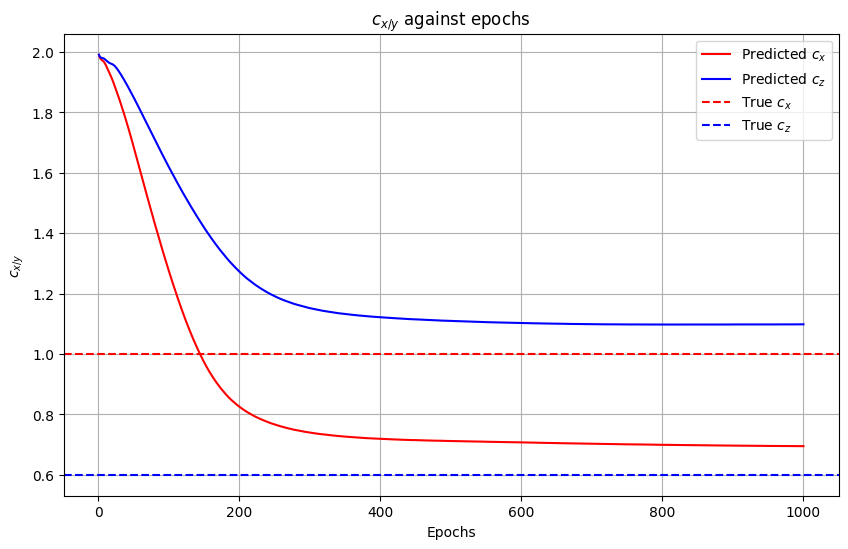

In [7]:
# Ensure 'parameter' contains the history of 'c_v' values
single = False

if single:
    cv_values = H_new.history['cv_inv']
    epochs = range(1, len(cv_values) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, cv_values, 'r-', label='Predicted $c_{v}$')
    plt.axhline(y=1.0, color='b', linestyle='--', label='True $c_{z}$')
    plt.xlabel('Epochs')
    plt.ylabel('$c_{X}$')
    plt.title('$c_{v}$ against epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig("InvertedCxCz_2D.png",dpi=600)
    plt.show()
    
else:
    cx_values = H_new.history['cx_inv']
    cz_values = H_new.history['cz_inv']
    epochs = range(1, len(cx_values) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, cx_values, 'r-', label='Predicted $c_{x}$')
    plt.plot(epochs, cz_values, 'b-', label='Predicted $c_{z}$')
    plt.axhline(y=1.0, color='r', linestyle='--', label='True $c_{x}$')
    plt.axhline(y=0.6, color='b', linestyle='--', label='True $c_{z}$')
    plt.xlabel('Epochs')
    plt.ylabel('$c_{x/y}$')
    plt.title('$c_{x/y}$ against epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig("InvertedCxCz_2D.png",dpi=600)
    plt.show()